# About

This notebook checks homogeneous of generated two training and holdout samples. One dimentional distributions for each varibale are compared between each samples type and multidimensional distributions are compared with machine learning.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import numpy
import root_numpy

## Read the data

In [3]:
data_full_train_big = pandas.DataFrame(root_numpy.root2array('../data/data_million_of_each_class_filtered.root', 'tree'))
data_full_train = pandas.concat([pandas.read_csv('../data/data_train_Long.csv'), 
                                 pandas.read_csv('../data/data_eval_Long.csv')])
data_full_holdout = pandas.read_csv('../data/shared_test_small.csv')

#### add signal column (from 0 to 5 classes), weights (to balance data), charges (to check assymetry)

In [4]:
from utils import compute_labels_and_weights, compute_charges, names_labels_correspondence, labels_names_correspondence
from utils import plot_hist_features, roc_auc_score_one_vs_all, compute_cum_sum, convert_DLL_to_LL

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
data_full_train['Signal'], data_full_train['Weight'] = compute_labels_and_weights(
    data_full_train.MCParticleType.values)
data_full_train_big['Signal'], data_full_train_big['Weight'] = compute_labels_and_weights(
    data_full_train_big.MCParticleType.values)
data_full_holdout['Signal'], data_full_holdout['Weight'] = compute_labels_and_weights(
    data_full_holdout.MCParticleType.values)

In [6]:
for i in range(6):
    print labels_names_correspondence[i]
    print '\t Natural training: %1.5f ' % (sum(data_full_train['Signal'] == i) * 100. / len(data_full_train)),
    print '\t Training: %1.5f ' % (sum(data_full_train_big['Signal'] == i) * 100. / len(data_full_train_big)),
    print '\t Holdout: %1.5f ' % (sum(data_full_holdout['Signal'] == i) * 100. / len(data_full_holdout))
    print '\t Natural training: %d' % sum(data_full_train['Signal'] == i),
    print '\t\t Training: %d' % sum(data_full_train_big['Signal'] == i),
    print '\t\t Holdout: %d' % sum(data_full_holdout['Signal'] == i)

Ghost
	 Natural training: 14.23414  	 Training: 17.84743  	 Holdout: 14.33320 
	 Natural training: 313151 		 Training: 1070846 		 Holdout: 143332
Electron
	 Natural training: 0.49214  	 Training: 15.48583  	 Holdout: 0.53790 
	 Natural training: 10827 		 Training: 929150 		 Holdout: 5379
Muon
	 Natural training: 3.24450  	 Training: 16.66668  	 Holdout: 4.21790 
	 Natural training: 71379 		 Training: 1000001 		 Holdout: 42179
Pion
	 Natural training: 64.22286  	 Training: 16.66668  	 Holdout: 63.78900 
	 Natural training: 1412903 		 Training: 1000001 		 Holdout: 637890
Kaon
	 Natural training: 11.07132  	 Training: 16.66668  	 Holdout: 10.52980 
	 Natural training: 243569 		 Training: 1000001 		 Holdout: 105298
Proton
	 Natural training: 6.73505  	 Training: 16.66668  	 Holdout: 6.59220 
	 Natural training: 148171 		 Training: 1000001 		 Holdout: 65922


# Compare features

In [7]:
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.metrics import roc_auc_score

def compare_data(data1, data2, weights1, weights2, features, ignored_sideband=0.05, particle=""):
    kw = {'bins': 60, 'alpha': 0.3, 'normed': True}
    k = int(numpy.ceil(len(features) / 6.))
    for n, f in enumerate(features):
        plt.subplot(k, 6, n + 1)
        val = data1[f].values
        v_min, v_max = numpy.percentile(val[val != -999], [ignored_sideband * 100, (1. - ignored_sideband) * 100])
        plt.hist(data1[f].values, weights=weights1, range=(v_min, v_max), **kw)
        plt.hist(data2[f].values, weights=weights2, range=(v_min, v_max), **kw)
        plt.title('%s: KS=%1.5f, AUC=%1.5f' % (particle, 
                                       ks_2samp_weighted(data1[f].values, data2[f].values, 
                                                         weights1, weights2),
                                       roc_auc_score([0] * len(data1) + [1] * len(data2),
                                                     numpy.concatenate([data1[f].values, data2[f].values]), 
                                                    sample_weight=numpy.concatenate([weights1, weights2])))
                 )
        plt.xlabel(f)

In [8]:
features_acceptance = ['InAccSpd', 'InAccPrs', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon']

#### train vs train big

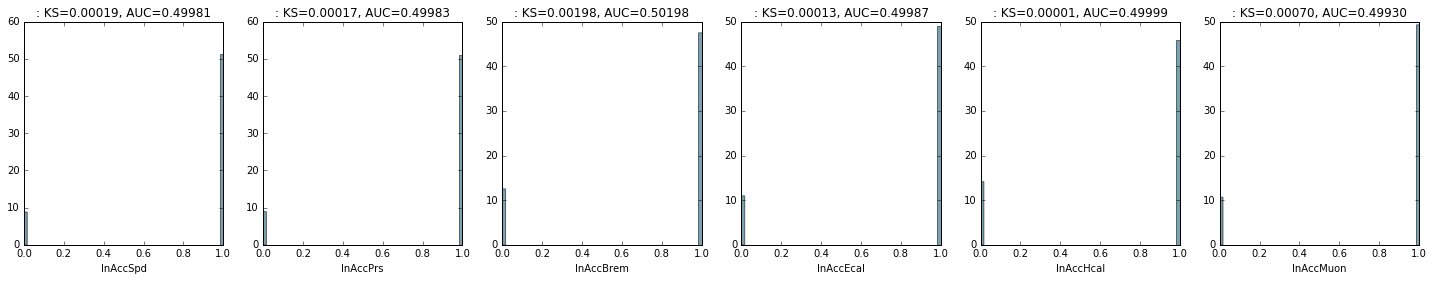

In [9]:
figure(figsize=(25, 4))
compare_data(data_full_train, data_full_train_big, 
             data_full_train.Weight.values, data_full_train_big.Weight.values, features_acceptance)

#### train big vs holdout

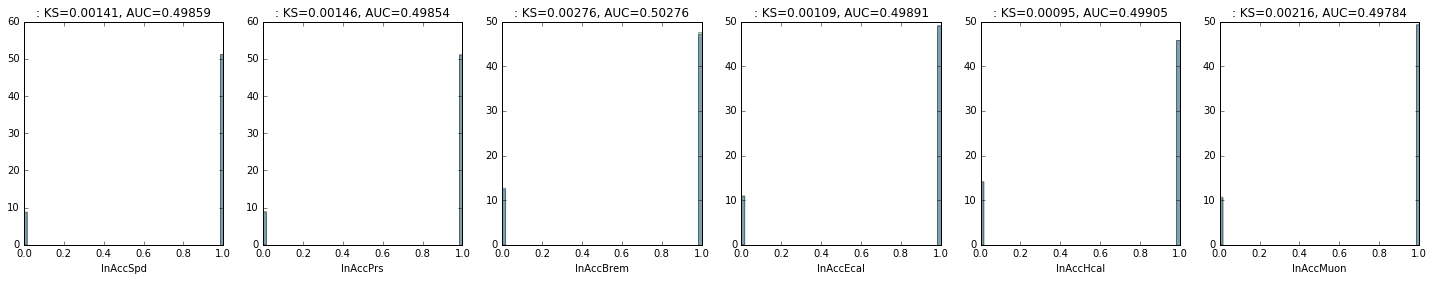

In [10]:
figure(figsize=(25, 4))
compare_data(data_full_holdout, data_full_train_big, 
             data_full_holdout.Weight.values, data_full_train_big.Weight.values, features_acceptance)

In [11]:
features_CALO_DLL_e = ['PrsPIDe', 'BremPIDe', 'EcalPIDe', 'HcalPIDe']
features_CALO_DLL_mu  = ['EcalPIDmu', 'HcalPIDmu']
features_CALO_E = ['CaloSpdE', 'CaloPrsE', 'CaloEcalE', 'CaloHcalE']
features_CALO_neutral  = ['CaloNeutralSpd', 'CaloNeutralPrs', 'CaloNeutralEcal']
features_CALO_charged = ['CaloChargedSpd', 'CaloChargedPrs' , 'CaloChargedEcal']
features_CALO_others = ['CaloBremMatch', 'CaloElectronMatch', 'CaloTrMatch', 'CaloTrajectoryL']
features_CALO = features_CALO_others + features_CALO_charged + features_CALO_neutral + features_CALO_E + \
    features_CALO_DLL_mu + features_CALO_DLL_e

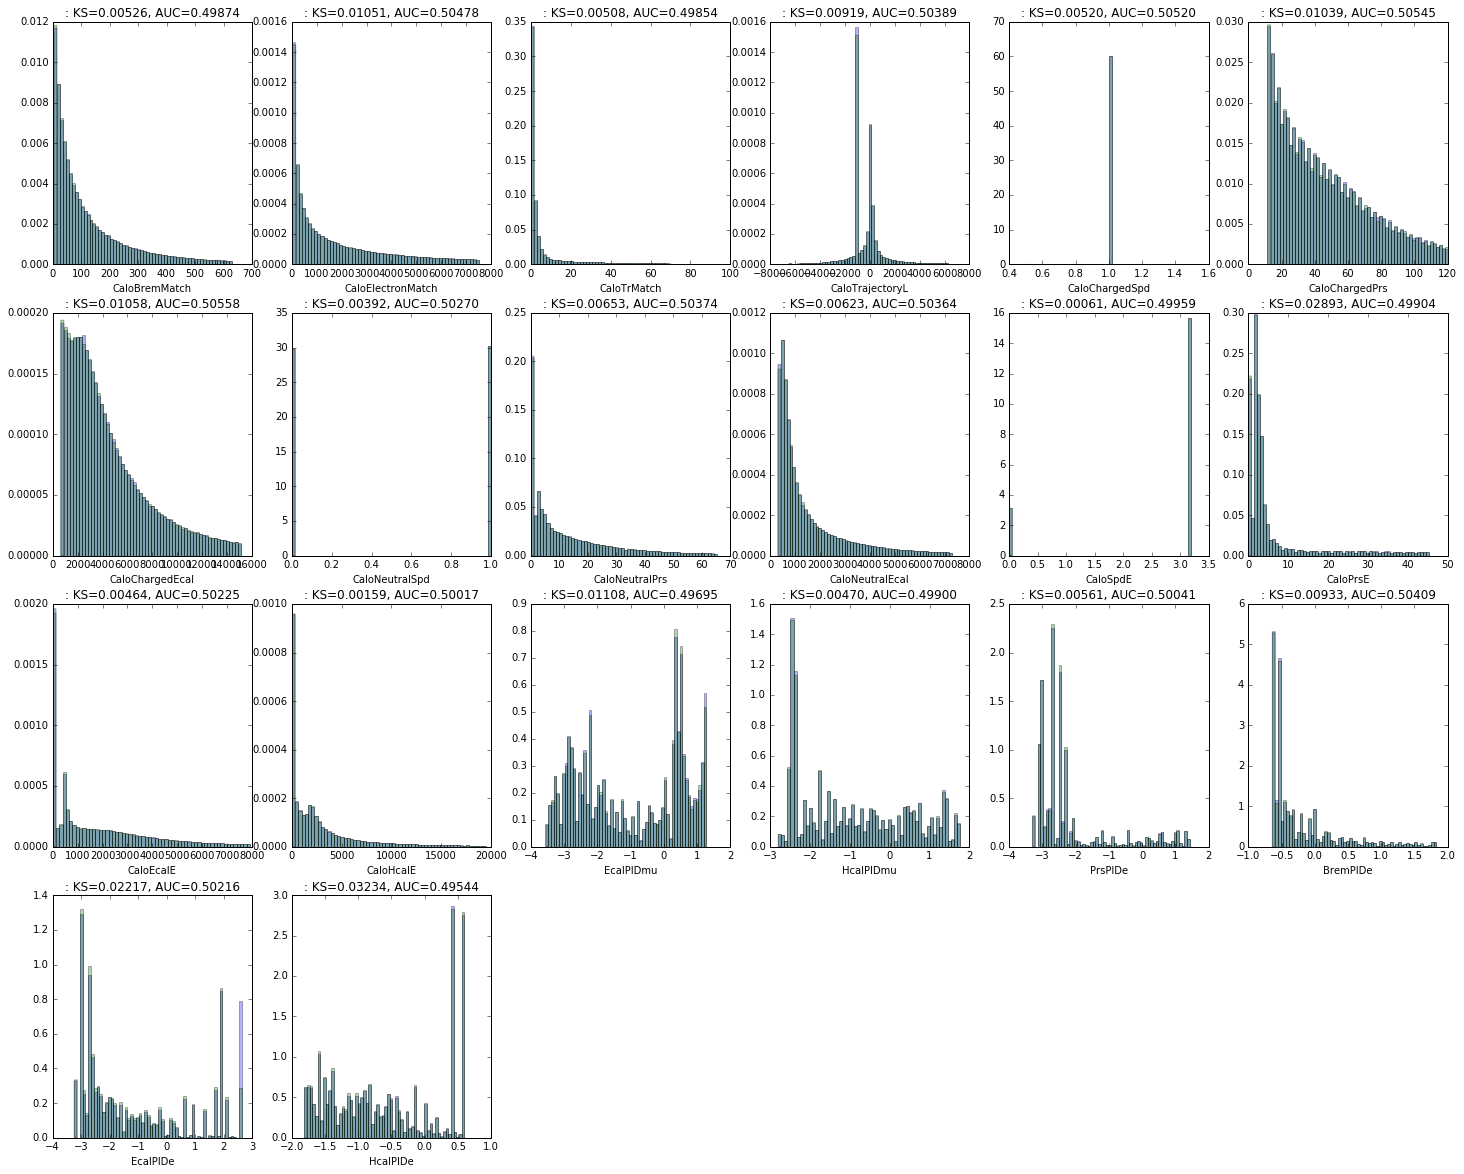

In [12]:
figure(figsize=(25, 20))
compare_data(data_full_train, data_full_train_big, 
             data_full_train.Weight.values, data_full_train_big.Weight.values, features_CALO)

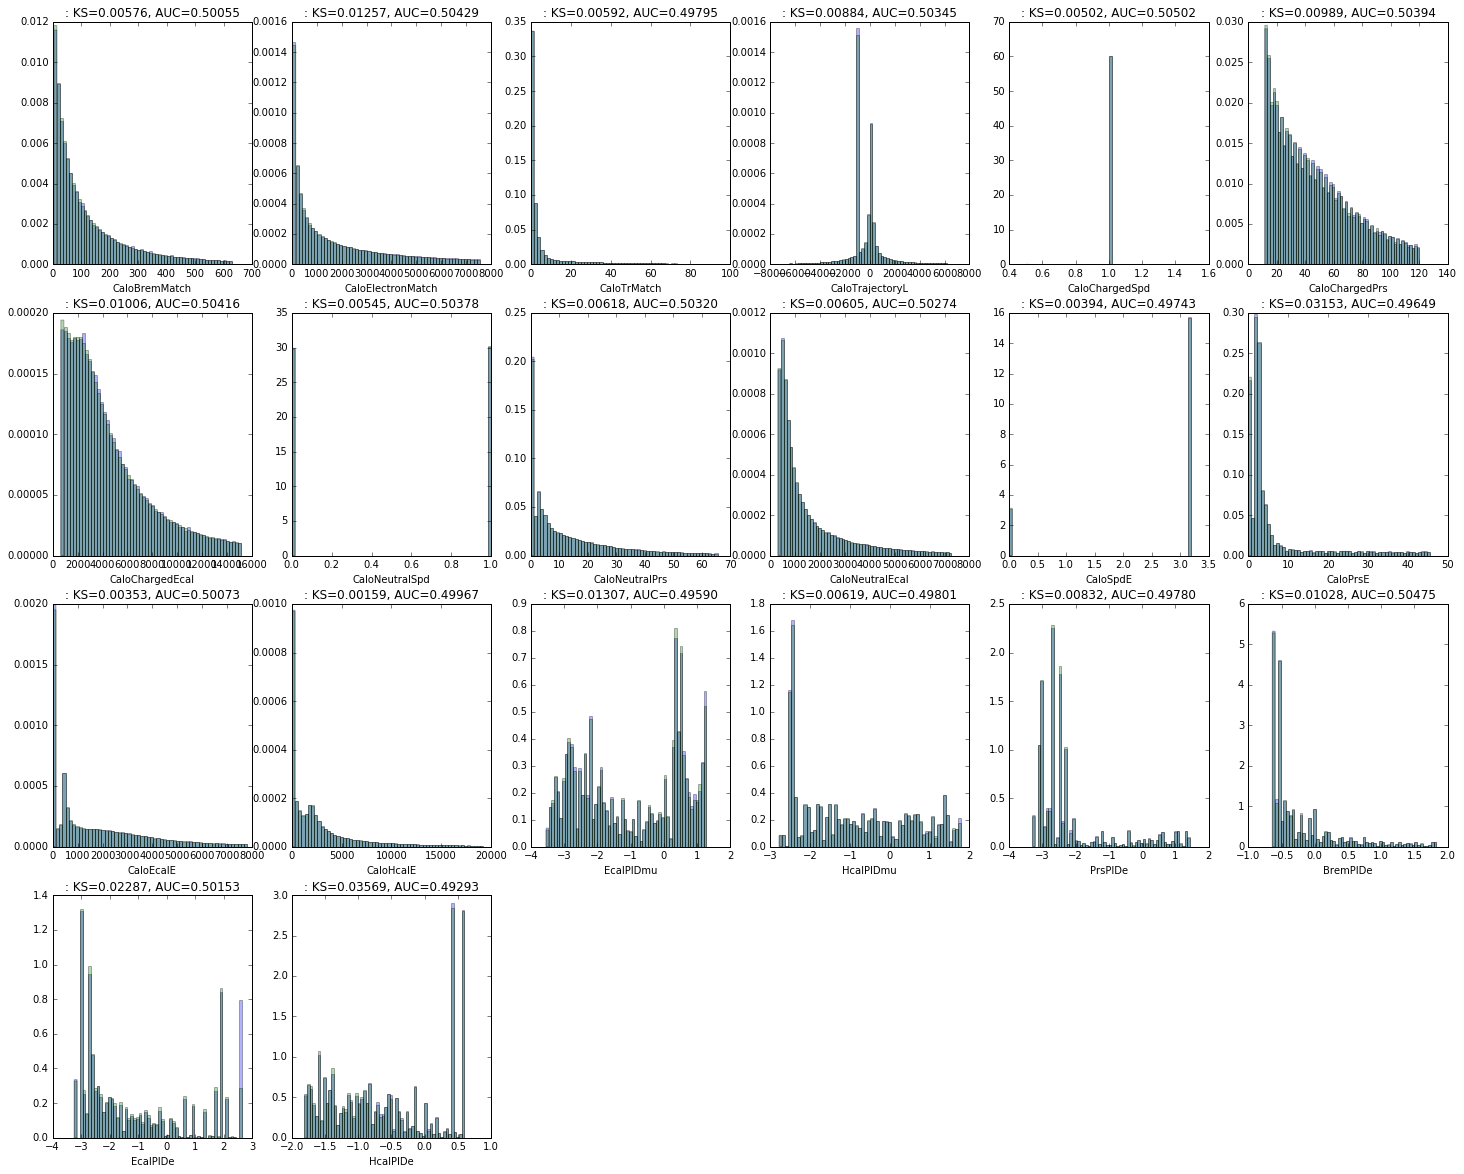

In [13]:
figure(figsize=(25, 20))
compare_data(data_full_holdout, data_full_train_big, 
             data_full_holdout.Weight.values, data_full_train_big.Weight.values, features_CALO)

In [14]:
features_RICH_DLL = filter(lambda x: 'RichDLL' in x, data_full_train.columns)
features_RICH_gas = ['RichUsedR1Gas', 'RichUsedR2Gas']
features_RICH_above = filter(lambda x: 'RichAbove' in x, data_full_train.columns)
features_RICH = features_RICH_above + features_RICH_gas + features_RICH_DLL

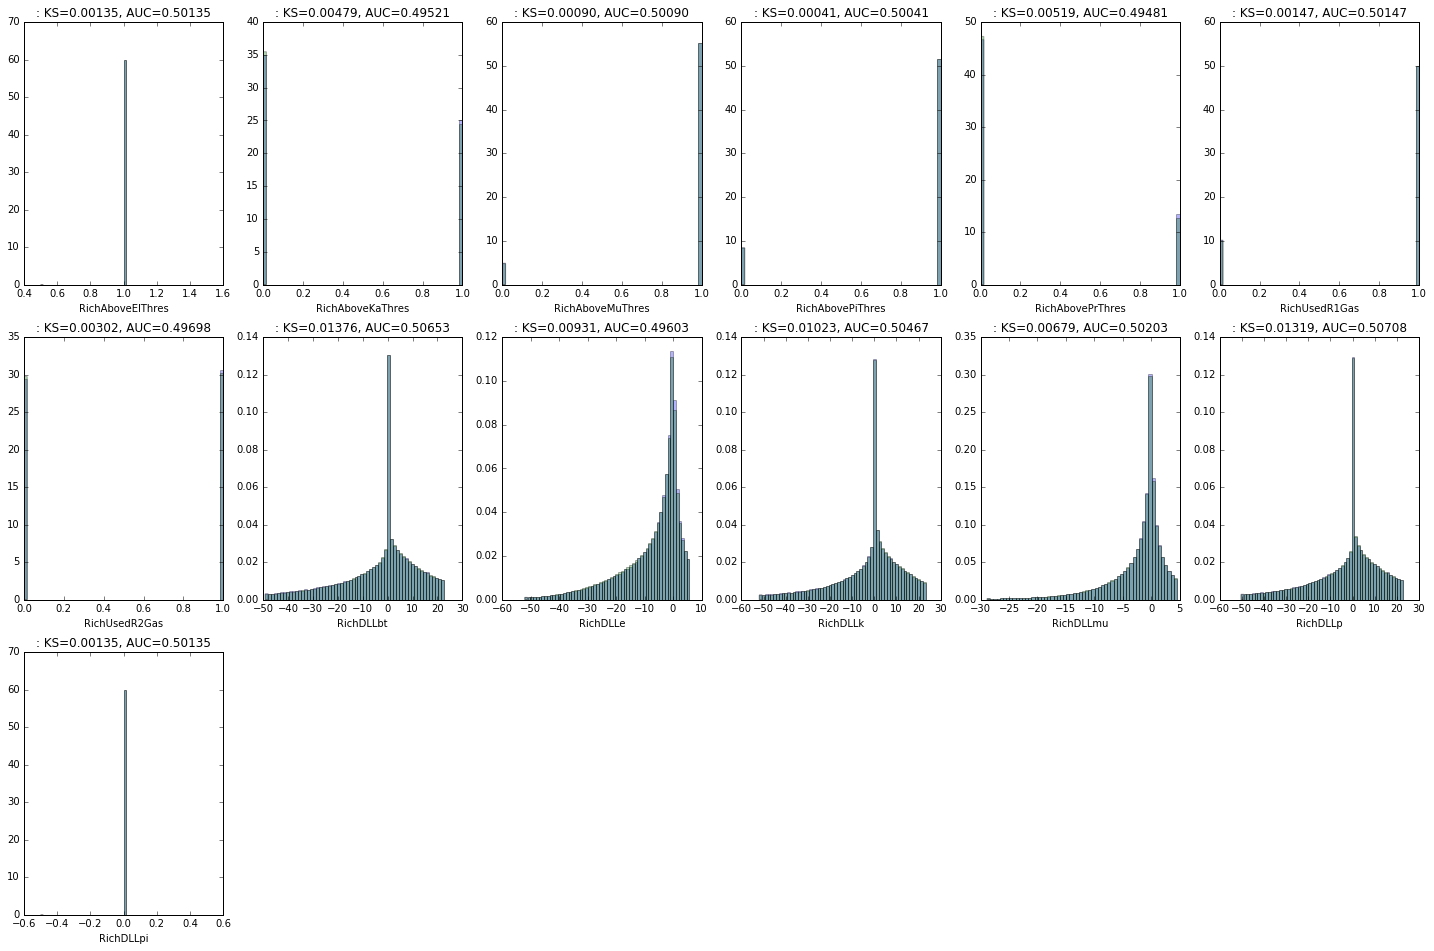

In [15]:
figure(figsize=(25, 16))
compare_data(data_full_train, data_full_train_big, 
             data_full_train.Weight.values, data_full_train_big.Weight.values, features_RICH)

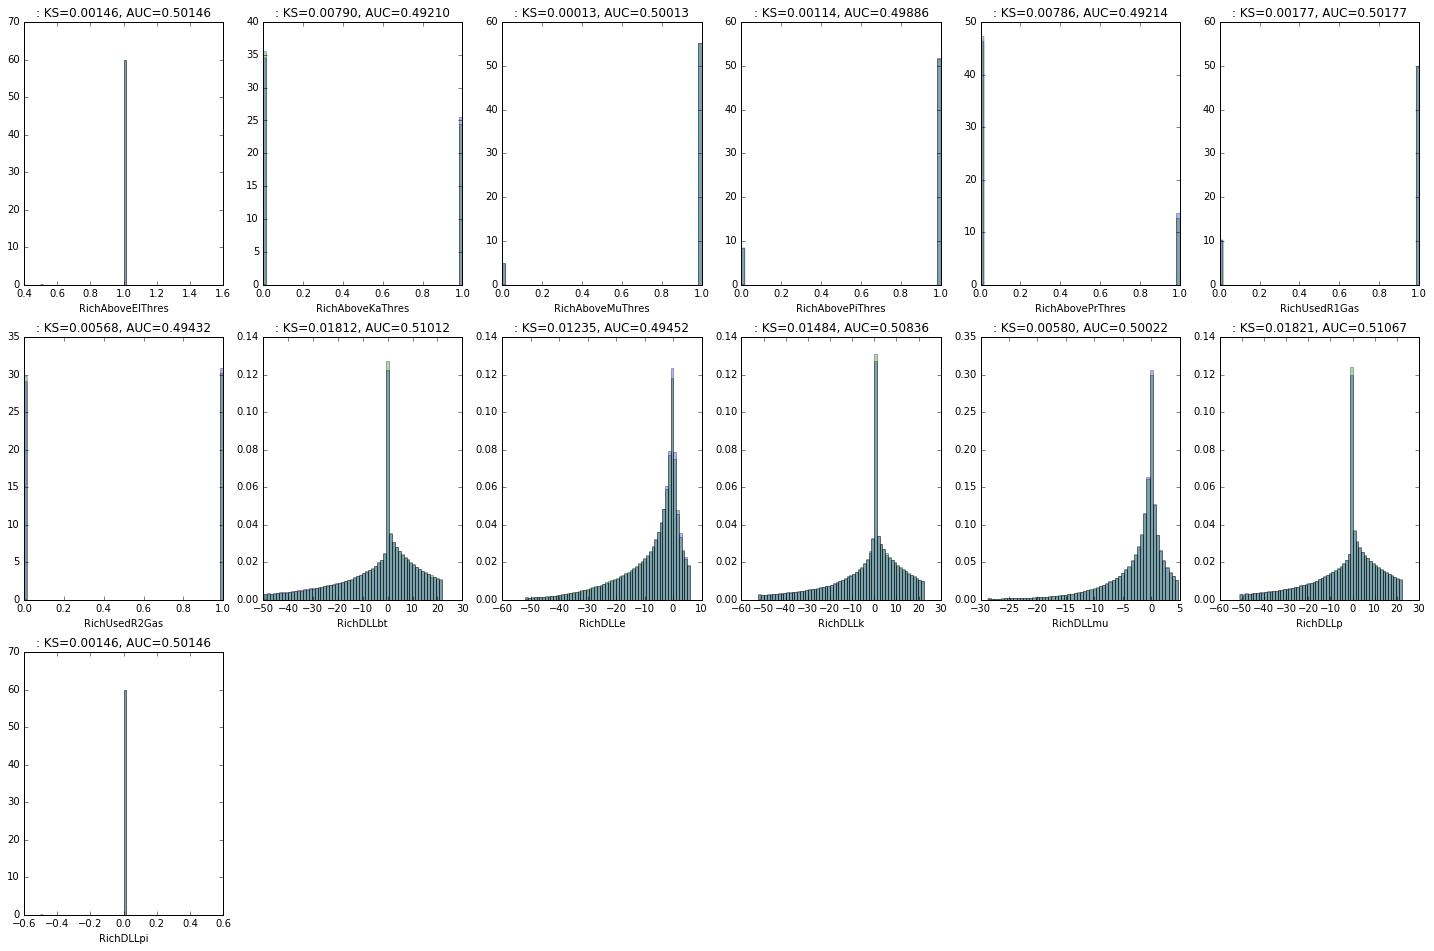

In [16]:
figure(figsize=(25, 16))
compare_data(data_full_holdout, data_full_train_big, 
             data_full_holdout.Weight.values, data_full_train_big.Weight.values, features_RICH)

In [17]:
features_Comb_DLL = filter(lambda x: 'CombDLL' in x, data_full_train.columns)

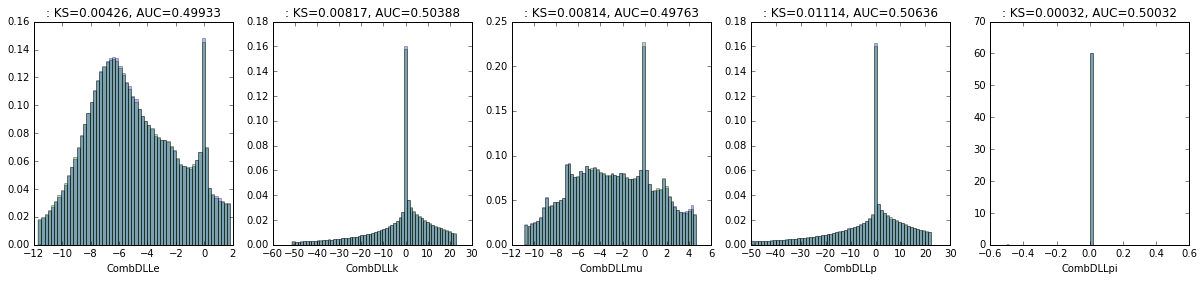

In [18]:
figure(figsize=(25, 4))
compare_data(data_full_train, data_full_train_big, 
             data_full_train.Weight.values, data_full_train_big.Weight.values, features_Comb_DLL)

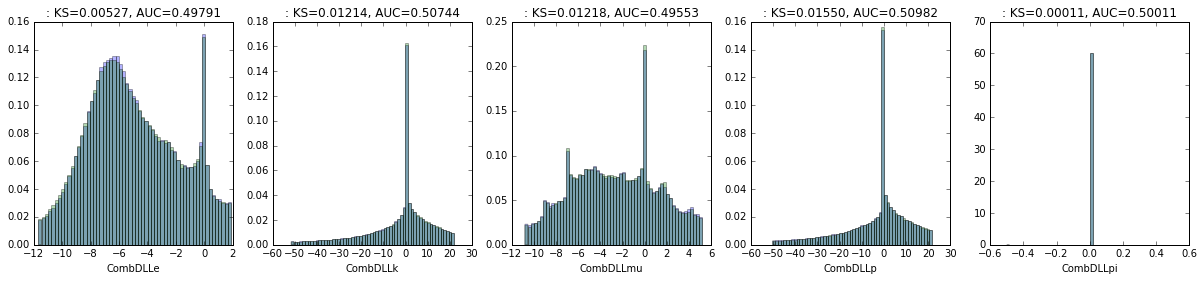

In [19]:
figure(figsize=(25, 4))
compare_data(data_full_holdout, data_full_train_big, 
             data_full_holdout.Weight.values, data_full_train_big.Weight.values, features_Comb_DLL)

In [20]:
features_track = filter(lambda x: 'Track' in x, data_full_train.columns) 
features_track = list(set(features_track) - {'TrackMatchChi2', 'TrackCloneDist', 'TrackType', 'TrackLikelihood',
                                            'NumMuonTracks', 'NumDownstreamTracks', 'NumLongTracks', 'NumVeloTracks',
                                            'NumUpstreamTracks', 'NumTTracks', 'TrackHistory',})

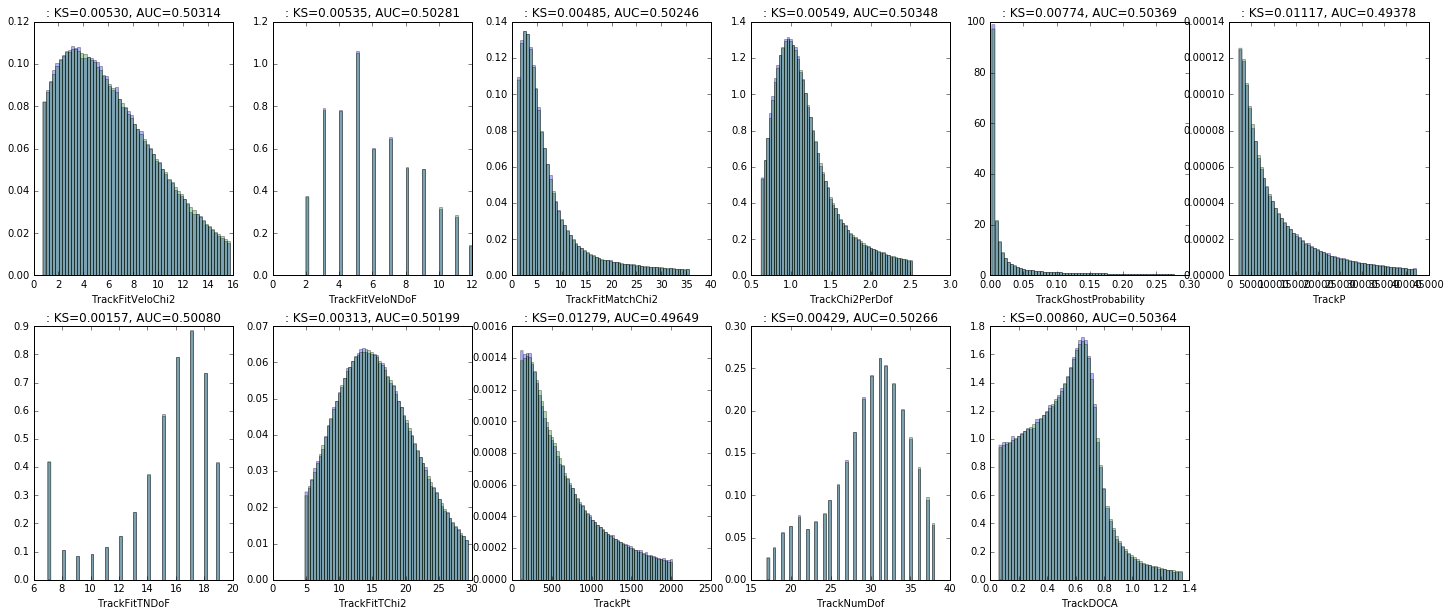

In [21]:
figure(figsize=(25, 10))
compare_data(data_full_train, data_full_train_big, 
             data_full_train.Weight.values, data_full_train_big.Weight.values, features_track)

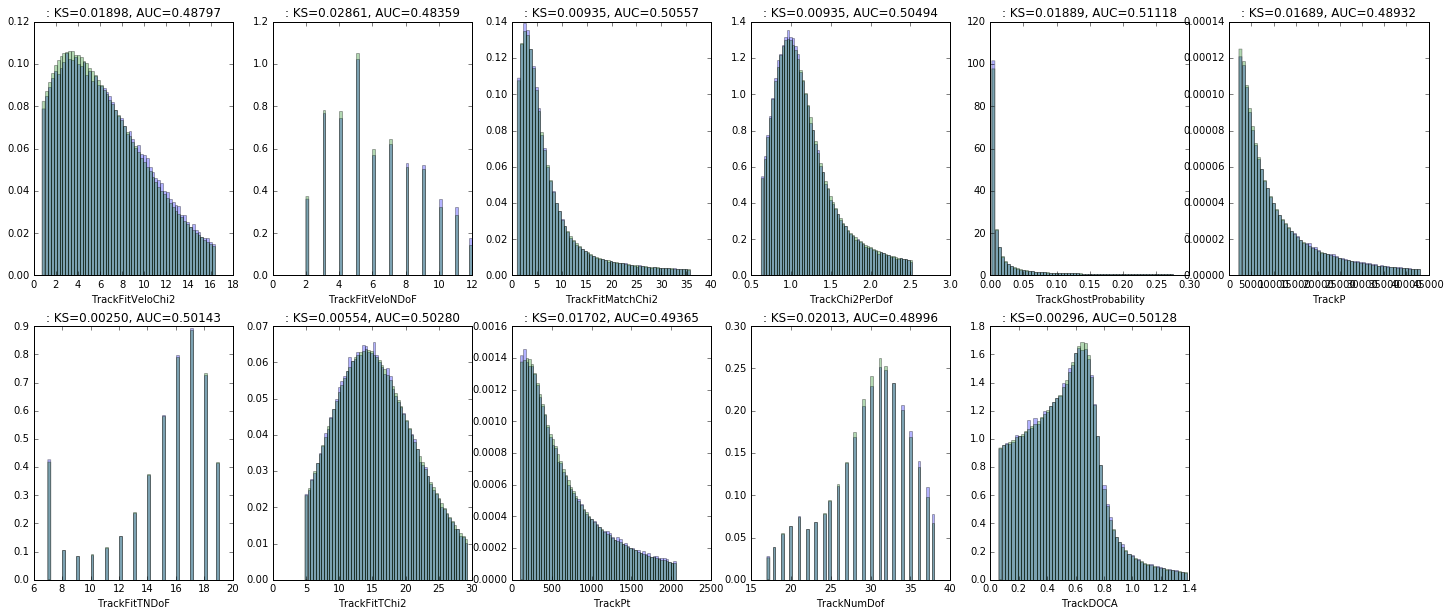

In [22]:
figure(figsize=(25, 10))
compare_data(data_full_holdout, data_full_train_big, 
             data_full_holdout.Weight.values, data_full_train_big.Weight.values, features_track)

In [23]:
features_muon = ['MuonNShared', 'MuonIsLooseMuon', 'MuonIsMuon', 'MuonBkgLL', 'MuonMuLL'] 

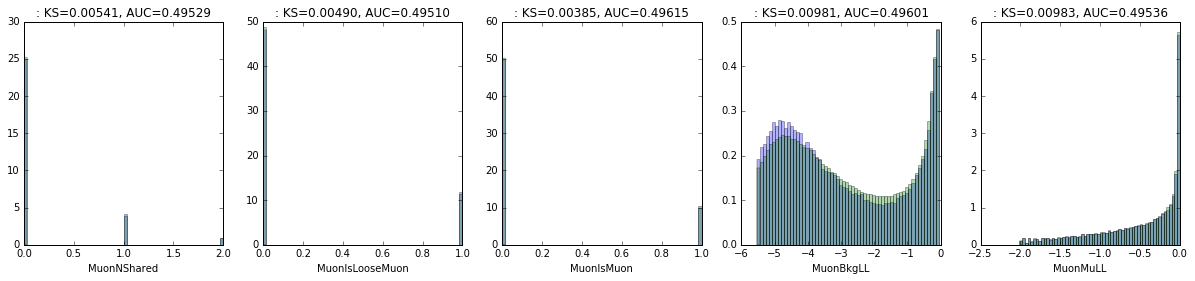

In [24]:
figure(figsize=(25, 4))
compare_data(data_full_train, data_full_train_big, 
             data_full_train.Weight.values, data_full_train_big.Weight.values, features_muon)

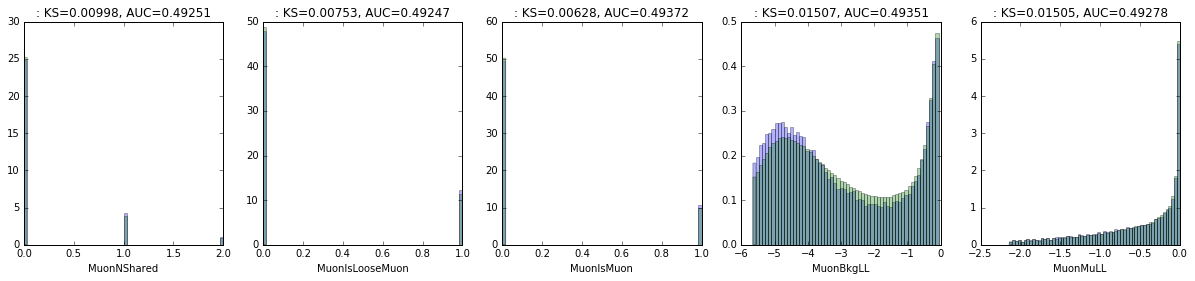

In [25]:
figure(figsize=(25, 4))
compare_data(data_full_holdout, data_full_train_big, 
             data_full_holdout.Weight.values, data_full_train_big.Weight.values, features_muon)

In [26]:
features_original = features_acceptance + features_CALO + features_RICH + features_Comb_DLL + features_track + features_muon

In [27]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier

# DT for each particle

In [28]:
from sklearn.cross_validation import train_test_split
def bootstrap_test_data(data1, data2, features, n_iter=30):
    aucs = {}
    for i in range(6):
        aucs[labels_names_correspondence[i]] = []
        vals = []
        for _ in range(n_iter):
            data1_train, data1_test = train_test_split(data1[data1.Signal == i], train_size=0.5)
            data2_train, data2_test = train_test_split(data2[data2.Signal == i], train_size=0.5)
            dt_p = SklearnClassifier(DecisionTrainClassifier(n_estimators=1000, depth=6, 
                                                             learning_rate=0.1, n_threads=12), 
                                     features=features)
            dt_p.fit(pandas.concat([data1_train, data2_train]),
                                    [0] * len(data1_train) + [1] * len(data2_train))
            p1 = dt_p.predict_proba(data1_test)[:, 1]
            p2 = dt_p.predict_proba(data2_test)[:, 1]
            vals.append(roc_auc_score([0] * len(data1_test) + [1] * len(data2_test), numpy.concatenate([p1, p2])))
        aucs[labels_names_correspondence[i]] = (numpy.mean(vals), numpy.std(vals)) 
        print labels_names_correspondence[i], aucs[labels_names_correspondence[i]][0], '+/-', 
        print aucs[labels_names_correspondence[i]][1]
    return aucs

In [29]:
aucs_train_holdout = bootstrap_test_data(data_full_train, data_full_holdout, features_original, n_iter=30)

Ghost 0.516347279205 +/- 0.00111750564644
Electron 0.512455735715 +/- 0.00460345785443
Muon 0.543181442986 +/- 0.00169497719292
Pion 0.534037908053 +/- 0.000382220280251
Kaon 0.526764891641 +/- 0.00142187211724
Proton 0.520270992996 +/- 0.00147264881247


In [30]:
aucs_train_holdout

{'Electron': (0.51245573571478609, 0.004603457854431712),
 'Ghost': (0.51634727920472456, 0.0011175056464368845),
 'Kaon': (0.52676489164102813, 0.0014218721172407146),
 'Muon': (0.54318144298609849, 0.0016949771929243131),
 'Pion': (0.53403790805270746, 0.00038222028025099153),
 'Proton': (0.52027099299614021, 0.001472648812469334)}

In [31]:
aucs_train_train_big = bootstrap_test_data(data_full_train, data_full_train_big, features_original, n_iter=30)

Ghost 0.523303246089 +/- 0.000703429509283
Electron 0.527276734857 +/- 0.00321811434279
Muon 0.585925245344 +/- 0.00100584953848
Pion 0.499645670366 +/- 0.000425477067428
Kaon 0.511492797314 +/- 0.00064390731783
Proton 0.511468368453 +/- 0.000758525932584


In [32]:
aucs_train_train_big

{'Electron': (0.52727673485695614, 0.0032181143427886089),
 'Ghost': (0.52330324608925904, 0.00070342950928292431),
 'Kaon': (0.51149279731411379, 0.00064390731783026014),
 'Muon': (0.58592524534386814, 0.0010058495384842596),
 'Pion': (0.49964567036566826, 0.00042547706742794512),
 'Proton': (0.51146836845299926, 0.00075852593258400928)}

In [33]:
aucs_train_big_holdout = bootstrap_test_data(data_full_train_big, data_full_holdout, features_original, n_iter=30)

Ghost 0.546009827261 +/- 0.000821037630103
Electron 0.521803595564 +/- 0.00419475711761
Muon 0.598092311141 +/- 0.00128614840799
Pion 0.552472640465 +/- 0.000463673255406
Kaon 0.527321931712 +/- 0.000852851488681
Proton 0.513378033223 +/- 0.00110176196957


In [34]:
aucs_train_big_holdout

{'Electron': (0.52180359556351918, 0.0041947571176050172),
 'Ghost': (0.54600982726145786, 0.00082103763010298383),
 'Kaon': (0.52732193171231934, 0.00085285148868079154),
 'Muon': (0.5980923111411246, 0.001286148407986858),
 'Pion': (0.55247264046547429, 0.00046367325540552957),
 'Proton': (0.51337803322289866, 0.0011017619695692818)}